In [1]:
variable_names = ['RRsgain (HP)', 'RRpgain (HP)', 'beta (UV)', 'alpha (UV)', 'beta_resp (ErvMAX)', 'beta_resp (ElvMAX)', 'alpha_resp (R)', 'alphav_resp (R)', 'RAP_setp', 
                  'ABP_setp', 'max_RV_E', 'min_RV_E', 'sys-dias_ratio', 'HR_t0', 'STS_pressure', 'STS_muscleP', 'grav_strong', 'global_R', 'global_UV', 
                  'R_p', 'E_arteries', 'E_veins', 'v_ratio', 'max_LV_E', 'min_LV_E', "baro_delay_para", "baro_delay_sympa", "baro_delay_BR_R",
                  "baro_delay_BR_UV", "baro_delay_CP_R", "baro_delay_CP_UV"]
a = len(variable_names)
a

31

In [ ]:
def dC_dt(): 
    # diffussion 
    diffusion = (k_c * s_v * phi_c)/(h_c * phi_t) * (C_c/alpha_b - C_t/alpha_t) 
    # consumption 
    consumption = (M_max * C_t)/(C_t + C_50) 
    return diffusion + consumption 

# time sacle 
t = np.linspace(0, 1000, 1000) # 1000秒，1000个点 


C_t = __
C_c = __

# solve 
solution = odeint(dC_dt, C_t, t, args=())


In [1]:
import matplotlib.pylab as plt


In [ ]:
store_oxygen =[[2.48556827e-04 2.37215464e-04 2.26053444e-04 2.14838874e-04
  2.04461558e-04 1.94414780e-04 1.84982100e-04 1.75794785e-04
  1.67007067e-04 1.58765593e-04 1.50848425e-04 1.43189754e-04
  1.36637549e-04 1.29008100e-04 1.22520329e-04 1.16282694e-04
  1.10358147e-04 1.04724525e-04 9.93513733e-05 9.42594144e-05
  8.94676780e-05 8.48244269e-05 8.05497861e-05 7.63409636e-05
  7.23882442e-05 6.87458316e-05 6.52265219e-05 6.18809221e-05
  5.87422570e-05 5.55140683e-05 5.29105426e-05 4.99269674e-05
  4.73253385e-05 4.48613816e-05 4.25542741e-05 4.03319859e-05
  3.82208049e-05 3.63040990e-05 3.43643642e-05 3.26070803e-05
  3.09215247e-05 2.93104962e-05 2.77693088e-05 2.62855673e-05
  2.49139945e-05 2.36140263e-05 2.23874998e-05 2.12626062e-05
  2.01802905e-05 1.91179028e-05 1.80911440e-05 1.71514024e-05
  1.62191477e-05 1.53881518e-05 1.45983195e-05 1.38115058e-05
  1.30962606e-05 1.24121911e-05 1.17617155e-05 1.11394987e-05
  1.05599628e-05 1.00004040e-05 9.47889922e-06 8.97897895e-06
  8.53061209e-06 8.06544930e-06 7.64839794e-06 7.24112249e-06]]

In [2]:
import numpy as np

a = np.zeros((2, 10))
print(a)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
global C_oxygen, k_c, h_c, s_v, alpha_b, alpha_t, M_max, C_50, phi_c, phi_t, C_t, C_c
# Oxygen        
C_oxygen = 0.35 # ml O2/ml blood
k_c = 4.2*10**(-14)
h_c = 1*10**(-6)
s_v = 4.74 *10**5
alpha_b = 3.11*10**(-5) # m3 O2 / mmHg*m3 blood
alpha_t = 3.95*10**(-5) # m3 O2 / mmHg*m3 blood
M_max = 2.4*10**(-4) # m3 O2 / mmHg*m3 blood
C_50 = 2.6*10**(-5) # m3 O2 / mmHg*m3 blood
phi_c = 0.011303
phi_t = 0.988697
C_t = 5.2*10**(-5) # m3 O2 / mmHg*m3 blood
C_c = 18*10**(-3) # 
q_in = 12.5     # mL blood /second
C_oxy_inlet = 0.018 # mol O2 / L blood
C_oxy = [0.018000000000000002,
0.01801412609563047,
0.018021128099442466,
0.018028170955578546,
0.018002825219126096,
0.018004235386929017,
0.0180056471838226,
0.018002208842707274,
0.018003311771512924,
0.01800441569594822,
0.018006622549487716,
0.018007724485053587,
0.018008827415352487,
0.018012563666585386,
0.018014427514077287,
0.018016294216555085,
0.018020228365461462,
0.018022190689342577,
0.0180241561836711]

def dC_dt(C_t):
    global k_c, s_v, phi_c, h_c, phi_t, alpha_b, alpha_t, M_max, C_50, C_c
    # diffusion
    diffusion = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_t / alpha_t))
    # consumption
    consumption = (M_max * C_t) / (C_t + C_50)
    
    return diffusion + consumption


C_oxy = np.array(C_oxy)  # 转换为 NumPy 数组
dcdt = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_oxy / alpha_t)) + (M_max * C_oxy) / (C_oxy + C_50)
dcdt
print(dcdt)


[0.02825219 0.0281708  0.02813045 0.02808988 0.02823591 0.02822779
 0.02821965 0.02823946 0.02823311 0.02822675 0.02821403 0.02820768
 0.02820133 0.0281798  0.02816906 0.02815831 0.02813564 0.02812433
 0.02811301]


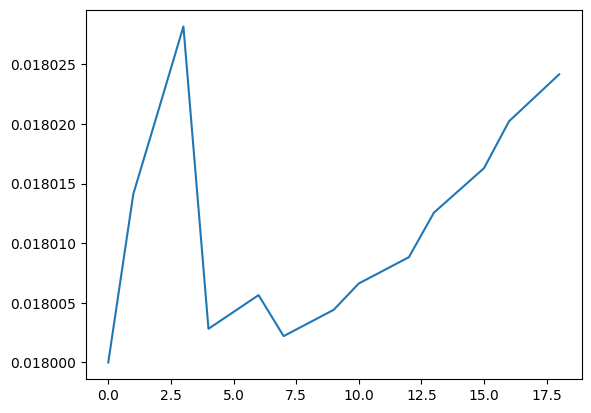

In [7]:
import matplotlib.pyplot as plt

plt.plot(C_oxy, label='Oxygen')

In [2]:
        # if oxy_switch == 1:
        #     # Calculate current dcdt
        #     dcdt = dC_dt(C_oxy)
            
        #     # Define oxygen reset interval (e.g. 1 second)
        #     oxy_reset_interval = 1.0  
            
        #     # Check if reset interval has elapsed
        #     if t - last_oxy_reset >= oxy_reset_interval:
        #         # Reset to initial values
        #         C_c = 5.2*10**(-5)  # m3 O2 / mmHg*m3 blood
        #         C_t = 18*10**(-3)  # m3 O2 / mmHg*m3 blood
        #         last_oxy_reset = t  # Update last reset time
        #     else:
        #         # Normal update during interval
        #         C_c -= dcdt
        #         C_t += dcdt

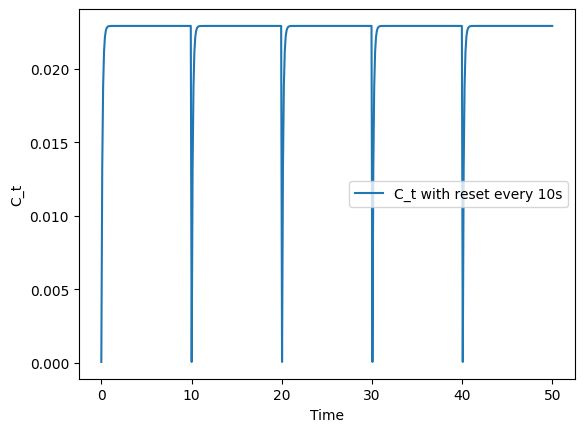

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
C_oxygen = 0.35 # ml O2/ml blood
k_c = 4.2*10**(-14)
h_c = 1*10**(-6)
s_v = 4.74 *10**5
alpha_b = 3.11*10**(-5) # m3 O2 / mmHg*m3 blood
alpha_t = 3.95*10**(-5) # m3 O2 / mmHg*m3 blood
M_max = 2.4*10**(-4) # m3 O2 / mmHg*m3 blood
C_50 = 2.6*10**(-5) # m3 O2 / mmHg*m3 blood
phi_c = 0.011303
phi_t = 0.988697
C_t = 5.2*10**(-5) # m3 O2 / mmHg*m3 blood
C_c = 18*10**(-3) # 
q_in = 12.5     # mL blood /second
C_oxy_inlet = 0.018 # mol O2 / L blood

# 初始条件
C_t0 = 5.2*10**(-5)
C_50 = C_t0 / 2  # 根据你的假设
dt = 0.1  # 时间步长
T = 50  # 总模拟时间
steps = int(T / dt)  # 计算步数

# 存储时间序列
C_t_values = np.zeros(steps)
C_t_values[0] = C_t0
time = np.linspace(0, T, steps)

# 定义 dC_t/dt
def dC_dt(C_t):
    diffusion = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_t / alpha_t))
    consumption = (M_max * C_t) / (C_t + C_50)
    return diffusion + consumption

# 欧拉法迭代
for i in range(1, steps):
    if i * dt % 10 == 0:  # 每 10s 重置 C_t
        C_t_values[i] = C_t0
    else:
        C_t_values[i] = C_t_values[i-1] + dt * dC_dt(C_t_values[i-1])

# 绘制结果
plt.plot(time, C_t_values, label="C_t with reset every 10s")
plt.xlabel("Time")
plt.ylabel("C_t")
plt.legend()
plt.show()


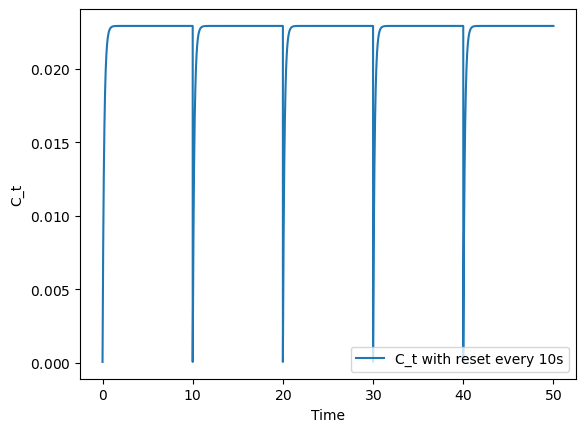

In [ ]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 定义微分方程
def dC_dt(C_t, t):
    diffusion = (k_c * s_v * phi_c / (h_c * phi_t)) * ((C_c / alpha_b) - (C_t / alpha_t))
    consumption = (M_max * C_t) / (C_t + C_50)
    return diffusion + consumption

# 设置时间区间
T = 50
dt = 0.01
time_segments = np.arange(0, T+dt, 10)  # 每 10s 一个区间
time_all = []
C_t_all = []

C_t_current = C_t0  # 初始值

for i in range(len(time_segments) - 1):
    t_range = np.linspace(time_segments[i], time_segments[i+1], int(10/dt))
    sol = odeint(dC_dt, C_t_current, t_range)  # 计算微分方程
    time_all.extend(t_range)
    C_t_all.extend(sol.flatten())
    C_t_current = C_t0  # 每 10s 重置

# 绘制结果
plt.plot(time_all, C_t_all, label="C_t with reset every 10s")

# 获取当前坐标轴
ax = plt.gca()

# 设置 x 轴为科学计数法
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))  # 设置科学计数法范围

# 设置 y 轴为科学计数法
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))

plt.xlabel("Time")
plt.ylabel("C_t")
plt.legend()
plt.show()



In [3]:
C_oxygen = 0.35 # ml O2/ml blood
k_c = 4.2*10**(-14)
h_c = 1*10**(-6)
s_v = 4.74 *10**5
alpha_b = 3.11*10**(-5) # m3 O2 / mmHg*m3 blood
alpha_t = 3.95*10**(-5) # m3 O2 / mmHg*m3 blood
M_max = 2.4*10**(-4) # m3 O2 / mmHg*m3 blood
C_50 = 2.6*10**(-5) # m3 O2 / mmHg*m3 blood
phi_c = 0.011303
phi_t = 0.988697
C_t = 4.5*10**(-5) # m3 O2 / mmHg*m3 blood
C_c = 5*10**(-4) # 

q_in = 12.5     # mL blood /second
C_oxy_inlet = 0.018 # mol O2 / L blood

C_O2Hb = 64 # umol/L
C_pa = C_c
V_pa = 10 # cm3
Q_pa = 12.5 # cm3/s

C_oxy = (Q_pa*10**(-6)*C_O2Hb*22.4*10**(-6) + C_pa*V_pa)/V_pa
C_oxy2 = (Q_pa*C_O2Hb*10**(-3) + C_pa*V_pa)/V_pa*10**(-6)*0.0224 # m3/m3
C_oxy3 = (Q_pa*10**(-6)*C_O2Hb*22.4+ C_pa*V_pa)/(V_pa) # m3/m3

In [4]:
print(C_oxy, C_oxy2)
print(C_oxy3)

0.000500001792 1.8032e-09
0.0022919999999999998
